# Machine Learning Model Notebook for On-Device Machine Learning for vibration based predictive maintainance of industrial induction motors using MEMS sensors.

### imports

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models, callbacks, utils

### file loading and hyperparameters

In [5]:
filemap = {
    'motor_off': 'motor_off.xlsx',
    'motor_on': 'motor_on.xlsx',
    'motor_on_nofan': 'motor_on_nofan.xlsx',
    'motor_on_badfan': 'motor_on_badfan.xlsx'
}
data_columns = ['ax','ay','az','gx','gy','gz']
label_column = 'class_label'
time_column = 'timestamp'
fs = 40.0

window_size = 256
step = 128

test_size = 0.2
val_size = 0.1

batch_size = 64
epochs = 60

In [6]:
frames = []

for label,fname in filemap.items():
    df = pd.read_excel(fname)
    frames.append(df)

df = pd.concat(frames)
print ('combined shape:', df.shape)

combined shape: (144000, 8)


## preprocessing

In [8]:
data_arr = df[data_columns].values.astype('float32')
labels_arr = df[label_column].values

print ('data shape (samples, channels):', data_arr.shape)

data shape (samples, channels): (144000, 6)


In [9]:
# sliding window generator

def make_windows(data, labels, window_size = window_size, step = step):
    x = []
    y = []
    n_samples = data.shape[0]

    for start in range(0, n_samples - window_size + 1, step):
        end = start + window_size
        win = data[start:end]
        lab_win = labels[start:end]
        vals, counts = np.unique(lab_win, return_counts = True)
        label = vals[np.argmax(counts)]
        x.append(win)
        y.append(label)
    X = np.array(x)
    y = np.array(y)
    return X,y

X,y = make_windows(data_arr, labels_arr, window_size, step)
print('windows created: X-shape:', X.shape, 'y shape:', y.shape)

windows created: X-shape: (1124, 256, 6) y shape: (1124,)


In [10]:
# encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
print('label classes:', le.classes_)

label classes: [0 1 2 3]


In [11]:
# train/test split (stratified by window label)
X_train, X_test, y_train, y_test = train_test_split (X, y_enc, test_size = test_size, stratify = y_enc)

In [12]:
# splitting train into training and validation
X_train, X_val, y_train, y_val = train_test_split (X_train, y_train, test_size = val_size, stratify = y_train)

In [13]:
print('train/test/val split shape:', X_train.shape, X_val.shape, X_test.shape)

train/test/val split shape: (809, 256, 6) (90, 256, 6) (225, 256, 6)


In [14]:
# scaling channels using standard scaler and then fitting on training windows + reshaping to fit scaler and then reshaping back
n_channels = X.shape[2]
scaler = StandardScaler()
reshaped = X_train.reshape(-1, n_channels)
scaler.fit(reshaped)

X_train_scaled = scaler.transform(X_train.reshape(-1, n_channels)).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, n_channels)).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, n_channels)).reshape(X_test.shape)

In [15]:
# converting labels to categorical
num_classes = len(le.classes_)
y_train_cat = utils.to_categorical(y_train, num_classes)
y_val_cat = utils.to_categorical(y_val, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

In [16]:


# For Keras: ensure dtype float32
#X_train_scaled = X_train_scaled.astype('float32')
#X_test_scaled = X_test_scaled.astype('float32')

## model architecture

In [18]:
model = models.Sequential([
    layers.Input(shape = (window_size, n_channels)),

    layers.Conv1D(32, kernel_size = 7, padding = 'same', kernel_regularizer = regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.SpatialDropout1D(0.2),
    layers.MaxPooling1D(2),

    layers.Conv1D(64, kernel_size = 5, padding = 'same', kernel_regularizer = regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.SpatialDropout1D(0.25),
    layers.MaxPooling1D(2),

    layers.Conv1D(32, kernel_size = 3, padding = 'same', kernel_regularizer = regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.GlobalAveragePooling1D(),

    layers.Dense(256, kernel_regularizer = regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(128, kernel_regularizer = regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(num_classes, activation = 'softmax')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 256, 32)        │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 256, 32)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 128, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 64, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             

 Total params: 61,764 (241.27 KB)

 Trainable params: 60,740 (237.27 KB)

 Non-trainable params: 1,024 (4.00 KB)

## model training

In [20]:
# callbacks
es = callbacks.EarlyStopping (monitor = 'val_loss', patience = 5, restore_best_weights = True)
rl = callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, min_lr = 1e-6)

In [21]:
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data = (X_val_scaled, y_val_cat),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [es,rl]
)

Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.2972 - loss: 1.5379 - val_accuracy: 0.2778 - val_loss: 1.3000 - learning_rate: 0.0010
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4678 - loss: 1.2853 - val_accuracy: 0.2889 - val_loss: 1.2326 - learning_rate: 0.0010
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5170 - loss: 1.1697 - val_accuracy: 0.4556 - val_loss: 1.1583 - learning_rate: 0.0010
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5591 - loss: 1.0396 - val_accuracy: 0.6000 - val_loss: 1.0609 - learning_rate: 0.0010
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5817 - loss: 0.9670 - val_accuracy: 0.8333 - val_loss: 0.9907 - learning_rate: 0.0010
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6444 - loss: 0.8584 - val_accuracy: 0.8778 - val_loss: 0.9281 - learning_rate: 0.0010
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6821 - loss: 0.7867 - val_acc

## evaluation

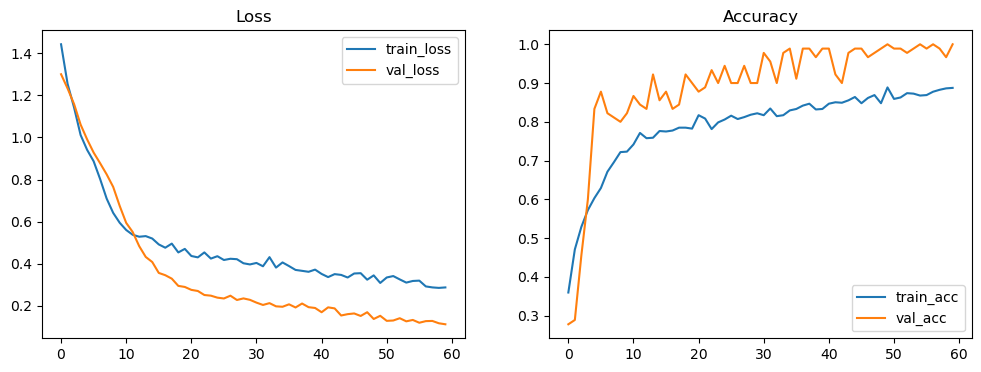

In [23]:
# training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [24]:
# eval
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_cat, verbose = 0)
print(f'test loss: {test_loss: .4f}, test accuracy:{test_acc: .4f}')

test loss:  0.2128, test accuracy: 0.9422


In [26]:
# predictions
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis = 1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [28]:
# classification report
print ('classification report:')
print(classification_report(y_test, y_pred, target_names = [str(c) for c in le.classes_]))

classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        57
           1       0.89      0.98      0.93        56
           2       0.89      0.89      0.89        56
           3       1.00      0.91      0.95        56

    accuracy                           0.94       225
   macro avg       0.94      0.94      0.94       225
weighted avg       0.95      0.94      0.94       225



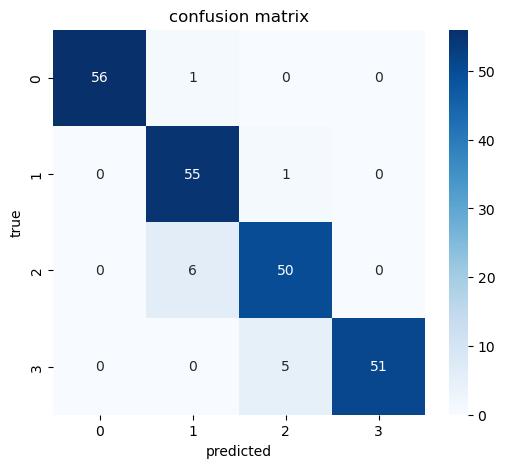

In [30]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6,5))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = le.classes_, yticklabels = le.classes_)
plt.xlabel('predicted')
plt.ylabel('true')
plt.title('confusion matrix')
plt.show()